For this first trial we assume a naive model (LGM) defined as:
$$dx_t = \sigma_t dW_t^{\mathit{N}}$$

Let's define the Numeraire as:
$$N(t, x_t) = \frac{1}{B(0,t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where $H_t$ and $\zeta_t$ are known functions.

With this let's defined the fundamental equation for the pricing of a derivative under the model. The NPV (Net Present Value) is:
$$V_t = V(t, x_t)$$ 
and the deflated version 
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$

#### Montecarlo simulation

* Brownian path:
$$W_t \sim \mathcal{N}(0,t)$$
$$W[0] = X_0$$
$$W[t] = W[t - 1]  + \mathcal{Z} \cdot \Delta t^{\frac{1}{2}}$$
with 
$$\mathcal{Z} \sim \mathcal{N}(0,1)$$
* X:
$$X_{t + 1} = X_t + \sigma \cdot (W_{t + 1} - W_t)$$

In [12]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from utils.simulator.simulator import MCSimulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Strike value
Vt = 2
T = 5
# Set of parameters
T, N_steps, X0, sigma = (T, 20, 0, 0.0075)
mcsimulator = MCSimulation(T, N_steps, X0, sigma)
nsims = int(1e2)
mc_paths, W = mcsimulator.simulate(nsims)
mc_paths_flatten = mc_paths.flatten('C')
deltaTs = np.linspace(0, T, N_steps)
deltaTs = np.tile(deltaTs.reshape(N_steps, 1), nsims).flatten()
df_x = pd.DataFrame(zip(
    deltaTs,
    mc_paths_flatten
), columns = ['dt', 'xt'])

#### Visualization

In [14]:
mc_paths_transpose = mc_paths.T
deltaTs = np.linspace(0, T, N_steps)

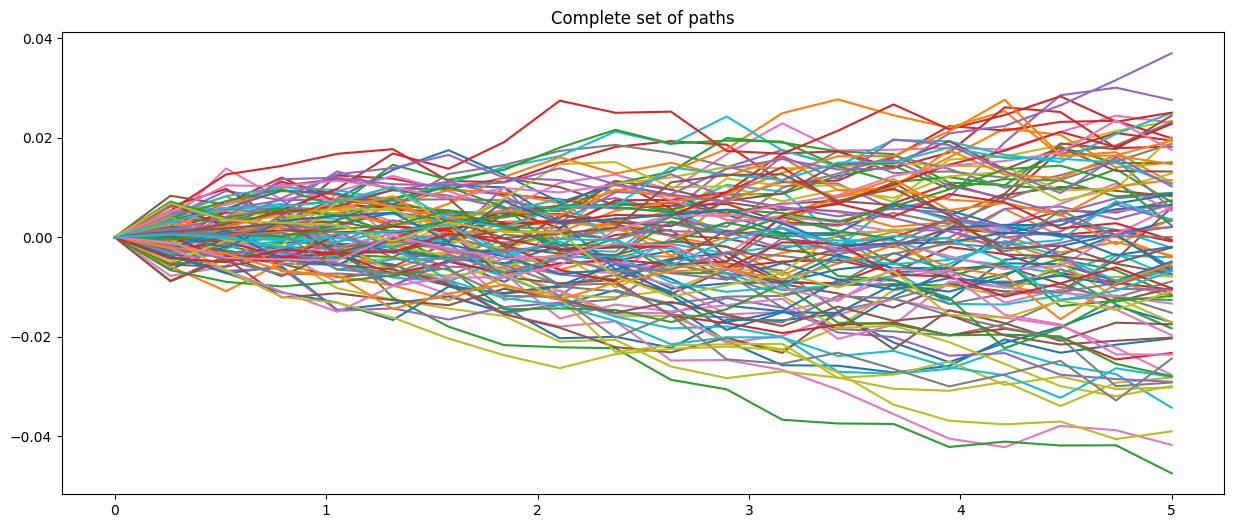

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
if nsims < 101:
    plt.figure(figsize = (15,6))
    plt.title('Complete set of paths')
    for vect in mc_paths_transpose:
        sns.lineplot(x = deltaTs, y = vect)
    plt.show()

#### Sanity with zero bond coupon

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

The sanity aims to retrieve the $D(t)$ after aggregating for each time step $t$ on the previous simulations. Steps:
* Calculate $Z(\cdot)$ for each timestep
* Calculate the numeraire $N(\cdot)$
* Get the $\hat{D}(t)$ for each path and time step as $\hat{D}(t) = \frac{Z(\cdot)}{N(\cdot)} \to E[\hat{D}(t)] = D(t)E[exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)] = D(T)exp(E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t]) = D(T)$
* Aggregate and compare the value with the theoretical $D(t)$

The final objective is to check that $E[-\frac{1}{2}H_T^2\zeta_t-H_Tx_t] = 0$

In [16]:
from utils.utils.utils import FinanceUtils, ZeroBound
t_unique = df_x.dt.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma = FinanceUtils.sigma) for dt in t_unique}
df_x['ct'] = df_x.apply(lambda x: dict_C[x['dt']], axis = 1)
xt, t, T, ct = df_x.xt, df_x.dt, T, df_x.ct
df_x['d_hat_t'] = ZeroBound.Z(xt, t, T, ct) / ZeroBound.N(t, xt, ct)
sanity = df_x.groupby(['dt']).agg(
    d_hat_t = ('d_hat_t', 'mean')
).reset_index()
sanity['dts'] = ZeroBound.D(np.array(sorted(t_unique)))

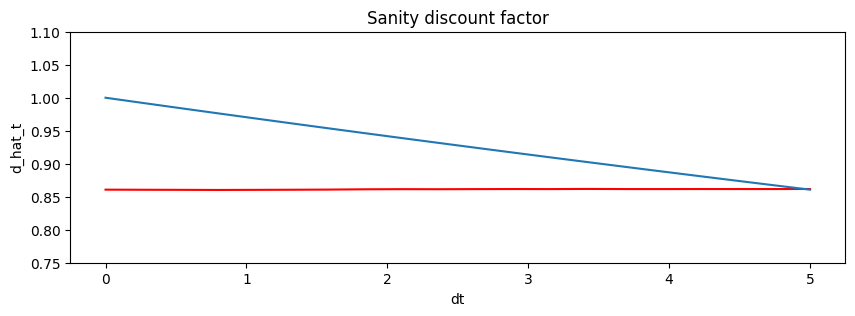

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
sns.lineplot(x = 'dt', y = 'd_hat_t', data = sanity, color = 'red')
sns.lineplot(x = 'dt', y = 'dts', data = sanity)
plt.ylim(0.75, 1.1)
plt.show()

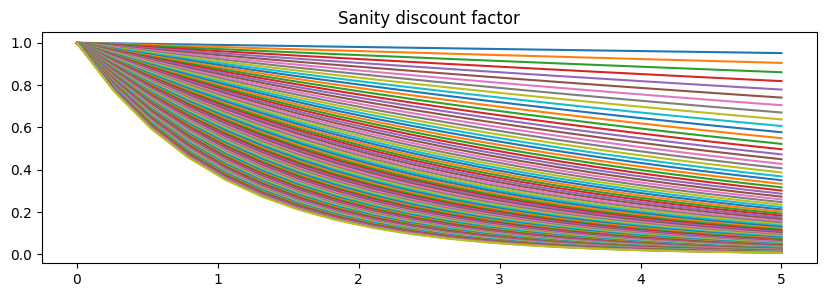

In [18]:
plt.figure(figsize = (10,3))
plt.title('Sanity discount factor')
for r in np.arange(0.01, 1.0, step = 0.01):
    sns.lineplot(x = t_unique, y = ZeroBound.D(np.array(sorted(t_unique)), r = r))
plt.show()

#### Seq2seq with feed forward neural networks

Check:
* https://towardsdatascience.com/how-to-use-custom-losses-with-custom-gradients-in-tensorflow-with-keras-e87f19d13bd5
* https://www.tensorflow.org/guide/autodiff

The idea is to include in the loss function the gradient tape to respect the model!!

In [19]:
# Tf imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

keras.backend.clear_session() 
keras.backend.set_floatx('float64')
tf.executing_eagerly()

True

In [82]:
# TODO: Write better method definitions
# TODO: Write better method definitions
class LGM_model_one_step(tf.keras.Model):

    def __init__(
        self,
        n_steps,
        T = 0,
        name="LGM_NN_model_single_step",
        verbose = False,
        **kwargs
    ):
        """_summary_

        Args:
            n_steps (_type_): _description_
            intermediate_dim (int, optional): _description_. Defaults to 64.
            is_sequential (bool, optional): _description_. Defaults to False.
            name (str, optional): _description_. Defaults to "LGM_NN_model".
        """
        super(LGM_model_one_step, self).__init__(name=name, **kwargs)
        self.N = n_steps
        self._custom_model = []
        for step in range(self.N):
            input_tmp = keras.Input(shape = (1, ), 
                                      name = 'input_nn_'+str(step))
            x = layers.Layer(trainable = False, 
                             name = 'adhoc_structure_layer_'+str(step)
                             )(input_tmp)
            initializer = tf.keras.initializers.GlorotUniform(seed = 6543210)
            output_tmp = layers.Dense(units = 1, 
                                        activation = 'relu', 
                                        name = 'dense_'+str(step),
                                        kernel_initializer = initializer)(x)
            self._custom_model.append(keras.Model(
                inputs = input_tmp,
                outputs = output_tmp,
                name = name))
        # Metrics tracker
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        # Internal management
        self._loss_tracker_t1 = tf.keras.metrics.Mean(name="loss")
        self._loss_tracker_t2 = tf.keras.metrics.Mean(name="loss")
        self._loss_tracker_t3 = tf.keras.metrics.Mean(name="loss")
        # Internal loss results
        self._loss_tracker_t1_array = []
        self._loss_tracker_t2_array = []
        self._loss_tracker_t3_array = []
        # Duration each step
        self._deltaT = T / self.N
        # Constantes:
        self._ct = FinanceUtils.C(T, sigma = FinanceUtils.sigma)
        # Status variables
        self._grads, self._predictions = None, None
        # Verbose
        self._verbose = verbose
    
    @property
    def model(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return self._custom_model
    
    @property
    def metrics(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return [self.loss_tracker, self.mae_metric]
    
    def summary(self):
        """_summary_
        """
        self._custom_model.summary()

    def call(self, inputs):
        """_summary_

        Args:
            inputs (_type_): _description_

        Returns:
            _type_: _description_
        """
        return self.predict(inputs)
    
    @tf.function
    def train_step(self, data):
        """_summary_

        Args:
            data (_type_): _description_

        Returns:
            _type_: _description_
        """
        x, y = data
        with tf.GradientTape() as tape:
            x = tf.Variable(x, trainable = True)
            v = self.predict(x)
            predictions = tf.Variable(self._predictions, trainable = False)   
            loss = self._loss_lgm(x = x, v = v, predictions = predictions, N_steps = N_steps)
        # Get trainable vars
        trainable_vars = self.trainable_weights
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(grads, trainable_vars))
        # Compute metrics
        self.loss_tracker.update_state(loss)
        # Valor erroneo
        self.mae_metric.update_state(v, y)
        return {"loss": self.loss_tracker.result(), "mae": self.mae_metric.result()}
    
    def define_compiler(self, optimizer = 'adam', learning_rate = 1e-3):
        """_summary_

        Args:
            optimizer (str, optional): _description_. Defaults to 'adam'.
            learning_rate (_type_, optional): _description_. Defaults to 1e-3.
        """
        if optimizer == 'adam':
            print(f'Optimizer set to {optimizer}')
            self._optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    def custom_train_step(self, X, y = None, epoch = 0, start_time = None):
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_, optional): _description_. Defaults to None.
            epoch (int, optional): _description_. Defaults to 0.

        Returns:
            _type_: _description_
        """
        x = tf.constant(X)
        with tf.GradientTape() as tape:
            v, predictions = self.predict(x)
            predictions = tf.Variable(predictions)   
            loss = self.loss_lgm(x = X, 
                                 v = v, 
                                 predictions = predictions, 
                                 N_steps = self.N,
                                 verbose = self._verbose)
        grads = tape.gradient(loss, self.model.trainable_weights)
        # print(f'Grads: {len(grads)}')
        self._optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        # Compute metrics
        self.loss_tracker.update_state(loss)
        if epoch % 100 == 0:
            if start_time is None:
                print(f'Epoch {epoch} Mean loss {self.loss_tracker.result()}')
            else:
                import time
                print(f'Epoch {epoch} Mean loss {self.loss_tracker.result()} Time per epoch: {(time.time() - start_time) / (epoch + 1)}s')
                print(f'\tPartial losses:\n\t\tStrike loss:{self._loss_tracker_t1.result()}\n\t\tDerivative loss: {self._loss_tracker_t2.result()}\n\t\tSteps loss: {self._loss_tracker_t3.result()}')
                self._loss_tracker_t1_array.append(self._loss_tracker_t1.result())
                self._loss_tracker_t2_array.append(self._loss_tracker_t2.result())
                self._loss_tracker_t3_array.append(self._loss_tracker_t3.result())         
        # Store losses
        return float(self.loss_tracker.result()), float(self._loss_tracker_t1.result()), float(self._loss_tracker_t2.result()), float(self._loss_tracker_t3.result())
    
    def get_losses_internal(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return self._loss_tracker_t1.result(), self._loss_tracker_t2.result(), self._loss_tracker_t3.result()
    
    def get_losses_internal_array(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return {'strike_loss': self._loss_tracker_t1_array, 
                'derivative_strike_loss': self._loss_tracker_t2_array, 
                'steps_error_loss': self._loss_tracker_t3_array}
    
    def export_model_architecture(self, dot_img_file = 'model_architectures/each_step_at_a_time.png'):
        return tf.keras.utils.plot_model(self._custom_model, to_file=dot_img_file, show_shapes=True)

    def _get_dv_dx(self, features):
        """_summary_

        Args:
            features (_type_): _description_

        Returns:
            _type_: _description_
        """
        samples, _ = features.shape
        grads = []
        for i in range(self.N):
            x_variable = tf.Variable(tf.reshape(features[:, i], (100,1)), name = 'x'+str(i))                
            with tf.GradientTape() as tape:
                y = self._custom_model[i](x_variable)
            # This represents dV/dX
            grads.append(tape.gradient(y, x_variable))
        self._grads = tf.reshape(tf.stack(grads), (samples, self.N))
        # Verbose to output
        if self._verbose:
            log_file = 'logs/20230217/grads_model.log'
            with open(log_file, 'a+') as f:
                f.write(f'Grads given X:\n')
                shape_x, shape_y = features.shape
                for x_i in range(shape_x):
                    for y_i in range(shape_y):
                        f.write(f'{features[x_i, y_i]},')
                    f.write(f'\n')
        # Sanity purposes:
        # print(f'Grads shape: {self._grads.shape}')
        return self._grads
    
    def _get_dv_dxi(self, i, sample_idx = None):
        """_summary_

        Args:
            i (_type_): _description_
            sample_idx (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        return self._grads[:, i] if self._grads is not None else None
    
    # TODO: Separate from the model
    def loss_lgm(self, x: tf.Tensor, v: tf.Tensor, predictions: tf.Tensor, N_steps: np.int64, verbose: bool = False):
        """_summary_

        Args:
            x (tf.Tensor): _description_
            v (tf.Tensor): _description_
            predictions (tf.Tensor): _description_
            N_steps (np.int64): _description_

        Returns:
            _type_: _description_
        """
        betas = [1.0, 1.0, 1.0]
        # Careful: Using global variable...
        len_path = N_steps
        # For f and f'
        xn_tensor = x[:, -1]
        n_idx = int(len_path)
        # Loss given the strike function
        tn = np.float64(self._deltaT * len_path)
        strike_loss = (predictions[:, -1] - FinanceUtils.zero_bond_coupon(xn_tensor, tn, self._ct))**2
        # Autodiff f
        xn = tf.Variable(x[:, -1], name = 'xn', trainable = True)
        tn = tf.Variable(np.float64(self._deltaT * len_path), name = 'tn', trainable=False)
        ct = tf.Variable(np.float64(self._ct), name = 'ct', trainable=False)
        with tf.GradientTape() as tape:
            y = FinanceUtils.zero_bond_coupon(xn, tn, ct)
        grad_df = tape.gradient(y, {
            'xn':xn   
        })
        df_dxn = grad_df['xn'] if grad_df['xn'] is not None else 0. * xn
        # Verbose to output
        if verbose:
            log_file = 'logs/20230217/grads_fx.log'
            with open(log_file, 'a+') as f:
                vector = x[:, -1]
                f.write(f'X:\n')
                for x_i in vector:
                    f.write(f'{x_i},')
                f.write(f'\n')
                f.write(f'Grads: \n')
                for grad_i in vector:
                    f.write(f'{grad_i},')
                f.write(f'\n')
        # Careful: global variable
        derivative_loss = betas[1] * (self._get_dv_dxi(n_idx - 1) - df_dxn)**2
        # Epoch error per step
        error_per_step = betas[2] * tf.reduce_sum(tf.math.squared_difference(v[:, :-1], predictions[:, :-1]), axis = 1)
        # Record internal losses
        self._loss_tracker_t1.update_state(strike_loss)
        self._loss_tracker_t2.update_state(derivative_loss)
        self._loss_tracker_t3.update_state(error_per_step)
        # Weigth the errors
        strike_loss *= betas[0]
        derivative_loss *= betas[1]
        error_per_step *= betas[2]
        
        return tf.math.add(error_per_step, tf.math.add(strike_loss, derivative_loss))

    def predict(self, X):
        """_summary_

        Args:
            X (_type_): _description_

        Returns:
            _type_: _description_
        """
        # Steps
        samples, N = X.shape
        # Swaping option at strike
        v = np.zeros((samples,N))
        predictions = []
        for i in range(self.N):
            predictions.append(self._custom_model[i](X[:, i]))
        predictions = tf.reshape(tf.stack(predictions), (samples, N))
        # Keep only the first value predicted
        v[:, 0] = predictions[:, 0]
        # Get the gradients
        grads = self._get_dv_dx(X)
        # Do the iterative process
        for i in range(0, self.N - 1):
            v[:, i + 1] = tf.math.add(v[:, i], tf.math.multiply(grads[:, i], tf.math.subtract(X[:, i + 1], X[:, i])))
            
        return v, predictions

#### Iterative process
* F - neural network function.
* $\frac{\delta F}{\delta X_t}^i$ - gradient calculated by using the model at $i$-iteration.
* $\phi(n, x_n)$ - known terminal function.


**Path generation**
$$\hat{V} = F(X)$$

$$\overline{V}_0 = \hat{V}^i[0]$$

$$\overline{V}_{t+1} = \overline{V}_t + \frac{\delta F(X)}{\delta x_t}(x_{t + 1} - x_{t})$$

**Loss function**
$$\mathcal{L}(\overline{V}, \hat{V}) = \beta_1 \cdot (\hat{V}_n - \phi(n, x_n))^2 + \beta_2\cdot (\frac{\delta \hat{V}_n}{\delta x_n} - \frac{\delta F(X)}{\delta x_n})^2 + \sum_{i = 1}^{n - 1}(\overline{V}_i - \hat{V}_i)^2$$

$\phi(\cdot)$:
* Constant function $f(x, n) = 1$
* IRS - TODO: Check
* Swaption - TODO: Check

Experiments:
* Terminal condition 1 - static case:
    * Train the network and do the sanity against the payoff for a Zero Bound Coupon $\overline{V}(x_t,t) = \frac{Z(t, x_t, T)}{N(x_t, t)}$
    * Second detail: The NN (predict vectorized) predicts the value $\overline{V}(x_t, t)$ which is our objective

Features shape: (100, 20)
Optimizer set to adam
Epoch 0 Mean loss 0.04829394453344275 Time per epoch: 1.9257290363311768s
	Partial losses:
		Strike loss:0.020748570996932836
		Derivative loss: 0.07470509637999566
		Steps loss: 0.002643674743178018
Epoch 100 Mean loss 0.039474767290599413 Time per epoch: 0.4606628630420949s
	Partial losses:
		Strike loss:0.02074268724834443
		Derivative loss: 0.048313376373116036
		Steps loss: 0.002627621251216323
Epoch 200 Mean loss 0.03513488422342655 Time per epoch: 0.4321776670009936s
	Partial losses:
		Strike loss:0.02069914293032761
		Derivative loss: 0.0353053034669536
		Steps loss: 0.0026673068041144538
Epoch 300 Mean loss 0.03221840281368624 Time per epoch: 0.42195820966828307s
	Partial losses:
		Strike loss:0.020660848846682088
		Derivative loss: 0.02659456447705229
		Steps loss: 0.002692699141320077
Epoch 400 Mean loss 0.03034719885143517 Time per epoch: 0.4190989777334313s
	Partial losses:
		Strike loss:0.02063336980403279
		Derivative loss:

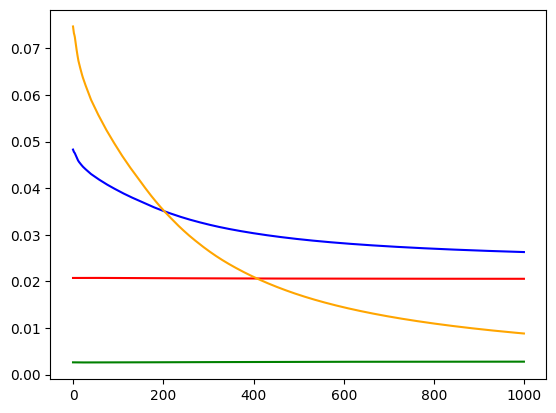

In [84]:
from model.model_lgm import LGM_model
import time
epochs = 1000
# Y 
y = None
# Custom model
lgm = LGM_model(N_steps, 64, verbose = True)
# Data used as features
x = np.reshape(mc_paths_transpose, (nsims, N_steps))
print(f'Features shape: {x.shape}')
# Compile the model
lgm.define_compiler(optimizer = 'adam', learning_rate = 1e-3)
# Losses:
losses_split = {
    'total': [],
    'strike_loss': [],
    'strike_derivative_loss': [],
    'steps_error': []
}
# Custom iteration: 
# TODO: translate into batch execution
start_time = time.time()
for epoch in range(epochs):
    el, sl, sdl, se = lgm.custom_train_step(X = x, epoch = epoch, start_time = start_time)
    losses_split['total'].append(
        el
    )
    losses_split['strike_loss'].append(
        sl
    )
    losses_split['strike_derivative_loss'].append(
        sdl
    )
    losses_split['steps_error'].append(
        se
    )
# Visualize errors
plt.figure()
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['total'], 
             color = 'blue')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['strike_loss'],
             color = 'red')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['strike_derivative_loss'],
             color = 'orange')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['steps_error'],
             color = 'green')
plt.show()

Features shape: (100, 20)
Optimizer set to adam
Epoch 0 Mean loss 0.026303130923042085 Time per epoch: 1.380248785018921s
	Partial losses:
		Strike loss:0.020569860297190705
		Derivative loss: 0.008824762366299602
		Steps loss: 0.002791683170418175
Epoch 100 Mean loss 0.026037429426248197 Time per epoch: 0.8414560284945044s
	Partial losses:
		Strike loss:0.020565338676185117
		Derivative loss: 0.008027455145561174
		Steps loss: 0.0027962723682093643
Epoch 200 Mean loss 0.025815802935987047 Time per epoch: 0.7482192729836079s
	Partial losses:
		Strike loss:0.020561674755024018
		Derivative loss: 0.007360511751518048
		Steps loss: 0.0028006242637903687
Epoch 300 Mean loss 0.0256282744524116 Time per epoch: 0.6910275509983203s
	Partial losses:
		Strike loss:0.020558575984887417
		Derivative loss: 0.006796096791116337
		Steps loss: 0.0028043328704854555
Epoch 400 Mean loss 0.025467516403056927 Time per epoch: 0.6847384059221072s
	Partial losses:
		Strike loss:0.020555919442242915
		Derivat

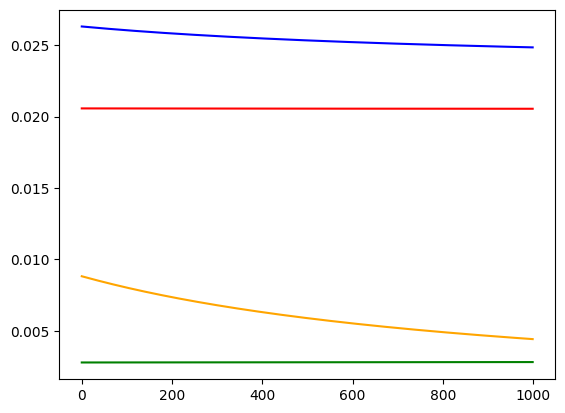

In [85]:
from model.model_lgm import LGM_model
import time
epochs = 1000
# Y 
y = None
# Custom model
lgm_single_step = LGM_model_one_step(N_steps, 64, verbose = True)
# Data used as features
x = np.reshape(mc_paths_transpose, (nsims, N_steps))
print(f'Features shape: {x.shape}')
# Compile the model
lgm.define_compiler(optimizer = 'adam', learning_rate = 1e-3)
# Losses:
losses_split = {
    'total': [],
    'strike_loss': [],
    'strike_derivative_loss': [],
    'steps_error': []
}
# Custom iteration: 
# TODO: translate into batch execution
start_time = time.time()
for epoch in range(epochs):
    el, sl, sdl, se = lgm.custom_train_step(X = x, epoch = epoch, start_time = start_time)
    losses_split['total'].append(
        el
    )
    losses_split['strike_loss'].append(
        sl
    )
    losses_split['strike_derivative_loss'].append(
        sdl
    )
    losses_split['steps_error'].append(
        se
    )
# Visualize errors
plt.figure()
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['total'], 
             color = 'blue')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['strike_loss'],
             color = 'red')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['strike_derivative_loss'],
             color = 'orange')
sns.lineplot(x = [i for i in range(1000)], 
             y = losses_split['steps_error'],
             color = 'green')
plt.show()

#### Sanity the NN

Once again we use the analytical solution for a ***Zero Coupon Bond***:

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ given and follows = $D(t) = e^{-rt}$, in this example with $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Discount factor (bono cupón 0 que paga 1 en T):

$$Z(x_t, t, T) = \frac{D(T)}{D(t)}exp-((H_T - H_t)x_t - \frac{1}{2}(H_T^2-H_t^2)\zeta_t) = \frac{D(T)}{D(t)}exp(-(H_T - H_t)x_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = $$
$$\frac{D(T)}{D(t)}exp(-H_Tx_t + H_tx_t - \frac{1}{2}H_T^2\zeta_t+\frac{1}{2}H_t^2\zeta_t) = \frac{D(T)}{D(t)}exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)exp(H_tx_t + \frac{1}{2}H_t^2\zeta_t) = $$
$$D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

In [86]:
v_lgm, predictions = lgm.predict(x)
v_lgm_single_step, predictions = lgm_single_step.predict(x)

In [87]:
v_df = pd.DataFrame(
    zip(v_lgm.flatten(),
        v_lgm_single_step.flatten(),
        np.tile(np.linspace(0, T, N_steps), nsims), 
        df_x['xt'].values.reshape(100, -1).T.flatten()), 
    columns = ['V_hat', 'V_hat_single_step', 'deltat', 'xt'])
t_unique = v_df.deltat.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma = FinanceUtils.sigma) for dt in t_unique}
v_df['ct'] = v_df.apply(lambda x: dict_C[x['deltat']], axis = 1)

In [88]:
v_df['V'] = v_df.apply(
    lambda x: 
        ZeroBound.Z(x.xt, x.deltat, T, x.ct) / ZeroBound.N(x.deltat, x.xt, x.ct), 
        axis = 1)

In [89]:
v_df

,V_hat,V_hat_single_step,deltat,xt,ct,V
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.860708
1,-0.000165,0.000000,0.263158,0.000000,0.000015,0.860706
2,-0.000794,0.000000,0.526316,0.000000,0.000030,0.860705
3,-0.001192,0.000000,0.789474,0.000000,0.000044,0.860703
4,-0.001013,0.000000,1.052632,0.000000,0.000059,0.860702
...,...,...,...,...,...,...
1995,0.008501,-0.000214,3.947368,-0.007894,0.000237,0.864086
1996,0.006390,-0.000076,4.210526,-0.034227,0.000256,0.875536
1997,0.009061,0.000158,4.473684,-0.006730,0.000275,0.863579
1998,0.006755,0.000158,4.736842,-0.028050,0.000294,0.872832
